# Summary

This notebook loads the final classification model used for bridge rating prediction. Specific features that influence prediction are extracted from the model and their relative importance is analyzed. 

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
from sklearn import metrics
from sklearn.externals import joblib

In [32]:
import folium

## Plot Settings

In [3]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=33) 
# axes label fontsize
plt.rc('axes', labelsize=28)
# axes values fontsize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# legend title fontsize
plt.rc('legend', title_fontsize=18)
# legend fontsize
plt.rc('legend', fontsize=18)

## Markdown Table

In [4]:
def mrkdwn_tbl(df):
    '''
    Return markdown code for formatted table
    Prints column names and all dataframe values
    
    Parameters
    ----------
    df : pandas dataframe 
    
    '''
    
    top_row = '| ' + ' | '.join(df.columns) + ' |'
    sec_row = '| ' + ' | '.join(['---'] * len(df.columns)) + ' |'
    print(top_row)
    print(sec_row)
    for i in range(len(df)):
        print('| ' + ' | '.join(df.iloc[i, :].astype(str).values) + ' |')

## Coordinate Function

In [5]:
# format NBI geogrpahic coordinates
def coords(lat, long, gps=False, n_s='N', e_w='W'):
    # latitude
    lat_deg = str(lat)[:2]
    lat_min = str(lat)[2:4]
    lat_sec = str(lat)[4:6] + '.' + str(lat)[6:]
    # longitude
    long_deg = str(long)[:2]
    long_min = str(long)[2:4]
    long_sec = str(long)[4:6] + '.' + str(long)[6:]
    
    # print as GPS format
    if gps==True:
        print(lat_deg + '°' + lat_min + '\'' + lat_sec + '\"' + n_s + ', ' \
              + long_deg + '°' + long_min + '\'' + long_sec + '\"' + e_w)
    
    # print as numerical format    
    else:
        sign_dict = {'N': '', 'S': '-', 'E': '', 'W': '-'}
        print(sign_dict[n_s] \
              + str(int(lat_deg) + int(lat_min)/60 + float(lat_sec)/3600) + ', ' \
              + sign_dict[e_w] \
              + str(int(long_deg) + int(long_min)/60 + float(long_sec)/3600)
             )

# Model Results

In [6]:
# load saved model
log_pipe = joblib.load('model_output/model.sav')

In [7]:
# load feature data
X = pd.read_csv('data/feat_df.csv', index_col=0)
features = X.columns

In [8]:
# load true classes
y = pd.read_csv('data/tru_cls.csv', index_col=0, header=None)

In [9]:
# load bridge ID info
br_id = pd.read_csv('data/bridges_id.csv', index_col=0)

In [10]:
# load bridge data
cats = pd.read_csv('data/bridges_cat.csv', index_col=0)

## Feature Affects

In [11]:
# import custom feature sorter class
from featuresorter import FeatureSort

In [12]:
# return top 10 feature weights
# note positive indicates tendency to poor class
feat_wgts = FeatureSort(log_pipe.named_steps['model'].coef_[0], features)
feat_wgts.sort_pct(10)

,feat_%,positive
SUFFICIENCY_RATING_feat_yr,14.1,False
SUPERSTRUCTURE_COND_059_8,7.1,False
DECK_STRUCTURE_TYPE_107_8,5.0,True
SUPERSTRUCTURE_COND_059_7,3.4,False
STRUCTURE_KIND_043A_1,3.1,False
SURFACE_TYPE_108A_3,2.8,False
HISTORY_037_4.0,2.4,True
FUNCTIONAL_CLASS_026_16.0,2.2,True
OPEN_CLOSED_POSTED_041_P,2.0,True
SERVICE_UND_042B_1,2.0,False


In [13]:
# percentage of model prediction based on top ten features
feat_wgts.sort_pct(10)['feat_%'].sum()

44.1

In [14]:
# feature labels based on NBI guide
labels = [
    'Suff. Rating', 
    'Super Cond. 8', 
    'Wood Deck', 
    'Super Cond. 7', 
    'Conc. Super', 
    'Latex W.S.', 
    'Hist. Undet.',
    'Urb. Min. Arterial',
    'Posted for Load',
    'Highway Below'
]

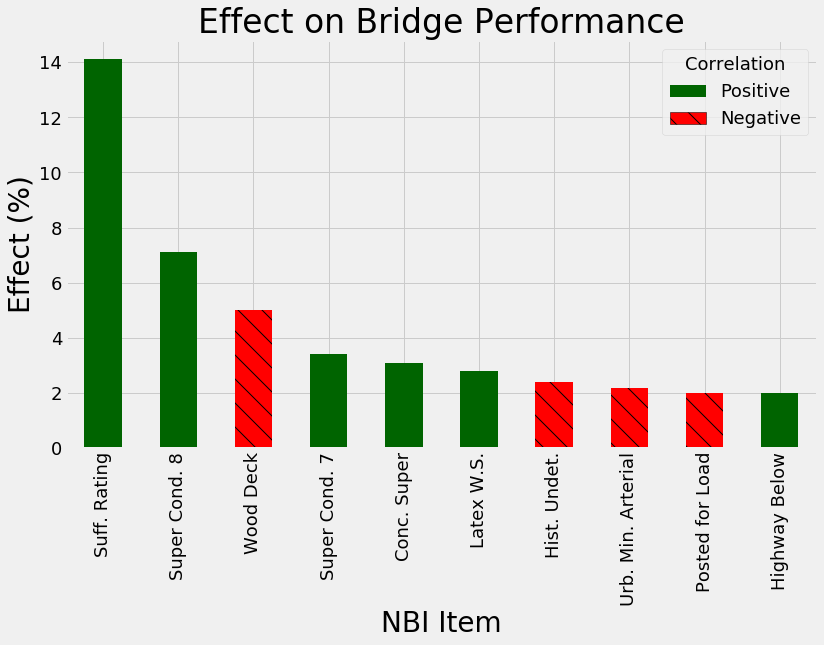

In [15]:
# plot most important features affecting predictions
feat_wgts.wgt_plot(
    feat_lab=labels, 
    title='Effect on Bridge Performance', 
    xlab='NBI Item', 
    ylab='Effect (%)',
    rev_col=True
)
# plt.savefig('model_output/feat_wgt.png', bbox_inches='tight')

**Note**: Model assumes 'poor' as positive class.  
For display, the signs are reversed so that 'positive' indicates a feature that increases a bridge's performance life.

## Sample Bridges

In [16]:
X.head()

,MIN_VERT_CLR_010,DETOUR_KILOS_019,AGE,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,...,SUPERSTRUCTURE_COND_059_6,SUPERSTRUCTURE_COND_059_7,SUPERSTRUCTURE_COND_059_8,SUPERSTRUCTURE_COND_059_9,SUPERSTRUCTURE_COND_059_N,SUBSTRUCTURE_COND_060_4,SUBSTRUCTURE_COND_060_5,SUBSTRUCTURE_COND_060_6,SUBSTRUCTURE_COND_060_7,SUBSTRUCTURE_COND_060_8
51-1VA3701,99.99,2.0,53.0,2.0,0,2000.0,7.9,45.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
51-1VA591A,99.99,4.0,42.0,2.0,0,50.0,6.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
51-2VA00AA,99.99,22.0,60.0,2.0,0,2000.0,6.1,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0
51-2VA00CC,99.99,6.0,60.0,2.0,0,1000.0,7.3,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
51-2VA00DD,99.99,12.0,60.0,2.0,0,500.0,6.1,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0


In [17]:
# average sufficiency rating
avg_SR = X['SUFFICIENCY_RATING_feat_yr'].mean()
avg_SR

69.71812080536903

In [18]:
# filter bridges for top six feature criteria
br_filt = X[
    (X['SUFFICIENCY_RATING_feat_yr'] < avg_SR) & # below average initial SR
    (X['SUPERSTRUCTURE_COND_059_8'] == 0) & # superstructure condition rating NOT 8
    (X['DECK_STRUCTURE_TYPE_107_8'] == 1) & # wood decks
    (X['SUPERSTRUCTURE_COND_059_7'] == 0) & # superstructure condition rating NOT 7
    (X['STRUCTURE_KIND_043A_1'] == 0) & # superstructure material NOT concrete
    (X['SURFACE_TYPE_108A_3'] == 0) # wearing surface NOT latex
 ]

In [19]:
# filter to bridges in Fairfax or Loudon counties
br_locs = br_id.loc[br_filt.index, :][(br_id.loc[br_filt.index, :]['COUNTY_CODE_003'] == 59) | 
                                      (br_id.loc[br_filt.index, :]['COUNTY_CODE_003'] == 107)]
br_locs

,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009,LAT_016,LONG_017
51-000000000006673,59.0,'POHICK CREEK ','OLD COLCHESTER RD.','0.90FR1 / 0.90TO242 ',38415400,77120600
51-11283,107.0,'RICHARDS CREEK ','ASH GEORGE ROAD ','00.45FR691/00.01TO694 ',39124800,77382400
51-11375,107.0,'SUGARLAND RUN ','THOMAS AVENUE ','00.10FR821/00.10TO793 ',38011200,77220000


In [20]:
# features for filtered bridges
br_feats = br_filt.loc[br_locs.index, :]
br_feats

,MIN_VERT_CLR_010,DETOUR_KILOS_019,AGE,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,...,SUPERSTRUCTURE_COND_059_6,SUPERSTRUCTURE_COND_059_7,SUPERSTRUCTURE_COND_059_8,SUPERSTRUCTURE_COND_059_9,SUPERSTRUCTURE_COND_059_N,SUBSTRUCTURE_COND_060_4,SUBSTRUCTURE_COND_060_5,SUBSTRUCTURE_COND_060_6,SUBSTRUCTURE_COND_060_7,SUBSTRUCTURE_COND_060_8
51-000000000006673,99.99,6.0,57.0,2.0,0,1983.0,6.4,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
51-11283,99.99,6.0,75.0,1.0,0,251.0,5.5,15.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0
51-11375,99.99,10.0,37.0,2.0,0,442.0,7.9,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0


In [21]:
# actual class
y.loc[br_locs.index, :]

,1
51-000000000006673,poor
51-11283,poor
51-11375,not poor


In [22]:
# return functional class and historical features
search = ['HISTORY', '026']
br_feats[br_feats.columns[br_feats.columns.str.contains('|'.join(search))]]

,FUNCTIONAL_CLASS_026_1.0,FUNCTIONAL_CLASS_026_11.0,FUNCTIONAL_CLASS_026_12.0,FUNCTIONAL_CLASS_026_14.0,FUNCTIONAL_CLASS_026_16.0,FUNCTIONAL_CLASS_026_17.0,FUNCTIONAL_CLASS_026_19.0,FUNCTIONAL_CLASS_026_2.0,FUNCTIONAL_CLASS_026_6.0,FUNCTIONAL_CLASS_026_7.0,FUNCTIONAL_CLASS_026_8.0,FUNCTIONAL_CLASS_026_9.0,HISTORY_037_1.0,HISTORY_037_2.0,HISTORY_037_3.0,HISTORY_037_4.0,HISTORY_037_5.0
51-000000000006673,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
51-11283,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
51-11375,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [23]:
# return posting and service under features
search = ['041', '042B']
br_feats[br_feats.columns[br_feats.columns.str.contains('|'.join(search))]]

,OPEN_CLOSED_POSTED_041_A,OPEN_CLOSED_POSTED_041_D,OPEN_CLOSED_POSTED_041_P,OPEN_CLOSED_POSTED_041_R,SERVICE_UND_042B_0,SERVICE_UND_042B_1,SERVICE_UND_042B_2,SERVICE_UND_042B_3,SERVICE_UND_042B_4,SERVICE_UND_042B_5,SERVICE_UND_042B_6,SERVICE_UND_042B_7,SERVICE_UND_042B_8
51-000000000006673,1,0,0,0,0,0,0,0,0,1,0,0,0
51-11283,0,0,1,0,0,0,0,0,0,1,0,0,0
51-11375,1,0,0,0,0,0,0,0,0,1,0,0,0


In [24]:
# ADT values
X.loc[br_locs.index, 'ADT_029']

51-000000000006673    1983.0
51-11283               251.0
51-11375               442.0
Name: ADT_029, dtype: float64

In [25]:
cat_list = [
    'SUPERSTRUCTURE_COND_059',
    'DECK_STRUCTURE_TYPE_107',
    'STRUCTURE_KIND_043A',
    'SURFACE_TYPE_108A',
    'HISTORY_037',
    'FUNCTIONAL_CLASS_026',
    'OPEN_CLOSED_POSTED_041',
    'SERVICE_UND_042B'
]

In [26]:
cats.loc[br_locs.index, :][cat_list]

,SUPERSTRUCTURE_COND_059,DECK_STRUCTURE_TYPE_107,STRUCTURE_KIND_043A,SURFACE_TYPE_108A,HISTORY_037,FUNCTIONAL_CLASS_026,OPEN_CLOSED_POSTED_041,SERVICE_UND_042B
51-000000000006673,5,8,3,0,5.0,17.0,A,5
51-11283,6,8,3,6,5.0,9.0,P,5
51-11375,6,8,3,6,5.0,19.0,A,5


Features:
- 06673
    - Deck Type: Wood
    - Superstructure Material: Steel
    - Wearing Surface: None
    - Functional Class: Urban Collector
    - Historical Sig: not eligible
    - Posting: open
    - Service under: waterway
- 11283
    - Deck Type: Wood
    - Superstructure Material: Steel
    - Wearing Surface: Bituminous
    - Functional Class: Rural Local
    - Historical Sig: not eligible
    - Posting: posted for load
    - Service under: waterway
- 11375
    - Deck Type: Wood
    - Superstructure Material: Steel
    - Wearing Surface: Bituminous
    - Functional Class: Urban Local
    - Historical Sig: not eligible
    - Posting: open
    - Service under: waterway

In [27]:
sum_table = {
    'Bridge': {0:'06673', 1:'11283', 2:'11375'},
    'County': {0:'Fairfax', 1:'Loudon', 2:'Loudon'},
    '2007 SR': {0:63.1, 1:50.4, 2:67.7},
    'Sup. Rating': {0:5, 1:6, 2:6},
    'Deck Type': {0:'Wood', 1:'Wood', 2:'Wood'},
    'Sup. Material': {0:'Steel', 1:'Steel', 2:'Steel'},
    'Wearing Surface': {0:'None', 1:'Asphalt', 2:'Asphalt'},
    'Functional Class': {0:'Urban Collector', 1:'Rural Local', 2:'Urban Local'},
    'Hist. Sig.': {0:'not eligible', 1:'not eligible', 2:'not eligible'},
    'Posting': {0:'Open', 1:'Load', 2:'Open'},
    'Service Under': {0:'Waterway', 1:'Waterway', 2:'Waterway'}
}

In [28]:
table_df = pd.DataFrame(sum_table)
table_df

,Bridge,County,2007 SR,Sup. Rating,Deck Type,Sup. Material,Wearing Surface,Functional Class,Hist. Sig.,Posting,Service Under
0,06673,Fairfax,63.1,5,Wood,Steel,None,Urban Collector,not eligible,Open,Waterway
1,11283,Loudon,50.4,6,Wood,Steel,Asphalt,Rural Local,not eligible,Load,Waterway
2,11375,Loudon,67.7,6,Wood,Steel,Asphalt,Urban Local,not eligible,Open,Waterway


In [29]:
# convert dataframe to markdown table code
mrkdwn_tbl(table_df)

| Bridge | County | 2007 SR | Sup. Rating | Deck Type | Sup. Material | Wearing Surface | Functional Class | Hist. Sig. | Posting | Service Under |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 06673 | Fairfax | 63.1 | 5 | Wood | Steel | None | Urban Collector | not eligible | Open | Waterway |
| 11283 | Loudon | 50.4 | 6 | Wood | Steel | Asphalt | Rural Local | not eligible | Load | Waterway |
| 11375 | Loudon | 67.7 | 6 | Wood | Steel | Asphalt | Urban Local | not eligible | Open | Waterway |


In [30]:
# bridge coordinates
br_locs[['LAT_016', 'LONG_017']]

,LAT_016,LONG_017
51-000000000006673,38415400,77120600
51-11283,39124800,77382400
51-11375,38011200,77220000


In [31]:
# true 11375 coords: 39.020589, -77.367820
br_locs.apply(lambda x: coords(x['LAT_016'], x['LONG_017']), axis=1)

38.69833333333333, -77.20166666666667
39.21333333333334, -77.64
38.019999999999996, -77.36666666666666


51-000000000006673    None
51-11283              None
51-11375              None
dtype: object

In [34]:
bridge_coords = [
    [38.69833333333333, -77.20166666666667],
    [39.21333333333334, -77.64],
    [39.020589, -77.367820]
]

In [39]:
map_center = [38.958142, -77.354406]

In [55]:
# plot coords on map
map = folium.Map(location=map_center, zoom_start=10)
for point in range(0, len(bridge_coords)):
    folium.Marker(bridge_coords[point]).add_to(map)
map